In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

# Reward Free RLとは？

参考：
* [Reward-Free Exploration for Reinforcement Learning](https://arxiv.org/abs/2002.02794)
* [Adaptive Reward-Free Exploration](https://arxiv.org/abs/2006.06294)


Reward Free RLでは報酬の情報無しで状態空間を効率よく探索することを考えます。
具体的には以下の手続きでアルゴリズムが進みます：

1. 何らかの方策を繰り返し実行し、データセット $\mathcal{D}=(s_1, a_1, s_2, a_2, \dots)$ を収集します。
2. 十分なデータセットが集まったと判断できたら、探索を終了します。
3. $\mathcal{D}$によって近似された遷移確率$\widehat{P}$と、与えられた報酬関数$r$で作られるMDPを解き、その最適方策$\widehat{\pi}_*$を返します。

Reward Freeの設定での性能を測るには、次のPAC RLを解くために必要なサンプル効率が便利です:


---

**定義：PAC algorithm for Reward Free RL**

$$
P\left(全ての報酬関数 rについて, |E_{s_1 \sim P_0} [V_1^*(s_1;r) - V_1^{\widehat{\pi}_*}(s_1;r)]| \leq \varepsilon\right) \geq 1 - \delta
$$
を満たしているアルゴリズムをReward Free RLでの($\varepsilon, \delta$)-PAC アルゴリズムと呼ぶ。

---

今回は[Adaptive Reward-Free Exploration](https://arxiv.org/abs/2006.06294)のReward-Free UCRLを実装してみます。特に６章の実験をやってみます。

In [4]:
import numpy as np
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

def create_rew_P(S: int, A: int):
    """ double_chain MDP (報酬関数, 遷移確率) を作成します
    詳しくは６章参照

    Args:
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ

    Returns:
        rew (float): 報酬関数
        P (float): 遷移確率
    """
    assert A == 2

    # 一番右側の状態で1がもらえます
    rew = np.zeros((S, 2))
    rew[-1] = 1.0

    # 1を選ぶと右に, 0を選ぶと左に動きます。0.1の確率で逆方向に動きます。
    P = np.zeros((S, A, S))
    for s in range(S):
        P[s, 0, max(0, s-1)] = 0.9 
        P[s, 0, min(s+1, S-1)] = 0.1 

        P[s, 1, max(0, s-1)] = 0.1 
        P[s, 1, min(s+1, S-1)] = 0.9 
    np.testing.assert_almost_equal(P.sum(axis=-1), 1)
    return jnp.array(rew), jnp.array(P)


class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # ホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


S = 30
A = 2
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.95
horizon = 20

# Double chain MDP を作ります
rew, P = create_rew_P(S, A)
double_chain = MDP(S_array, A_array, gamma, horizon, rew, P)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# 実験に便利な関数

実験の前に、いくつか便利な関数を導入します。

1. ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
2. ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
3. ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
4. ``compute_optimality_gap``: 方策 $\pi$ と最適解との差 $\|q_* - q_{\pi}\|_\infty$ を返します。この値が小さいほど、$\pi$ はほぼ全ての状態行動対で最適な方策になっています。
5. ``sample_next_state``: $(s, a)$の次の状態をサンプルします。
6. ``sample_eps_greedy_act``: 与えられたQ値から、epsilon-greedy方策に従って行動を返します

In [5]:
from functools import partial
from tqdm import tqdm
import random


# >>>> 1 >>>>
@jax.jit
def compute_greedy_policy(Q: np.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy
# <<<< 1 <<<<


# >>>> 2 >>>>
@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        greedy_policy = compute_greedy_policy(optimal_Q)
        max_Q = (greedy_policy * optimal_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)
# <<<< 2 <<<<


# >>>> 3 >>>>
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, policy_Q)
# <<<< 3 <<<<


# >>>> 4 >>>>
@jax.jit
def compute_optimality_gap(mdp: MDP, policy: np.ndarray):
    policy_Q = compute_policy_Q(mdp, policy)
    optimality_gap = jnp.abs(mdp.optimal_Q - policy_Q).max()
    return optimality_gap
# <<<< 4 <<<<


# >>>> 5 >>>>
def sample_next_state(mdp: MDP, s: int, a: int):
    """ sample next state according to the transition matrix P
    Args:
        mdp: MDP
        s: int
        a: int
    Returns:
        next_s: int
    """
    probs = np.array(mdp.P[s, a])
    return np.random.choice(mdp.S_array, p=probs)
# <<<< 5 <<<<


# >>>> 6 >>>>
def sample_eps_greedy_act(mdp: MDP, q_s: np.array, eps: float):
    if random.random() < eps:
        return random.randint(0, mdp.A-1)
    else:
        return q_s.argmax()
# <<<< 6 <<<<

double_chain = double_chain._replace(optimal_Q=compute_optimal_Q(double_chain))

早速アルゴリズムを比較していきましょう。Figure2を再現できるように実装していきます。

In [58]:
import matplotlib.pyplot as plt
from itertools import product
import chex


def random_explore(mdp: MDP, samples_to_collect: int):
    S, A = mdp.S, mdp.A
    horizon = mdp.horizon

    visit_SA = np.zeros((S, A))
    visit_SAS = np.zeros((S, A, S))
    P_approx = np.ones((S, A, S)) / S

    num_sample = 0
    init_s = int((mdp.S - 1) / 2)
    gaps = []
    num_samples = []
    while num_sample < samples_to_collect:
        s = init_s
        for _ in range(horizon):
            a = random.randint(0, mdp.A - 1)  # ランダムな行動を選択します
            visit_SA[s, a] += 1
            next_s = sample_next_state(mdp, s, a)
            visit_SAS[s, a, next_s] += 1
            P_approx[s, a] = visit_SAS[s, a] / visit_SA[s, a]
            s = next_s
            num_sample += 1

        mdp_approx = mdp._replace(P=P_approx)
        mdp_approx = mdp_approx._replace(optimal_Q=compute_optimal_Q(mdp_approx))
        optimality_gap = np.abs(mdp.optimal_Q[init_s].max() - mdp_approx.optimal_Q[init_s].max())
        num_samples.append(num_sample)
        gaps.append(optimality_gap)
    return num_samples, visit_SA, gaps


def generative_model(mdp: MDP, samples_to_collect: int):
    S, A = mdp.S, mdp.A

    visit_SA = np.zeros((S, A))
    visit_SAS = np.zeros((S, A, S))
    P_approx = np.ones((S, A, S)) / S

    num_sample = 0
    init_s = int((mdp.S - 1) / 2)
    gaps = []
    num_samples = []
    while num_sample < samples_to_collect:
        for s, a in product(range(S), range(A)):
            visit_SA[s, a] += 1
            next_s = sample_next_state(mdp, s, a)
            visit_SAS[s, a, next_s] += 1
            P_approx[s, a] = visit_SAS[s, a] / visit_SA[s, a]
            s = next_s
            num_sample += 1

        mdp_approx = mdp._replace(P=P_approx)
        mdp_approx = mdp_approx._replace(optimal_Q=compute_optimal_Q(mdp_approx))
        optimality_gap = np.abs(mdp.optimal_Q[init_s].max() - mdp_approx.optimal_Q[init_s].max())
        num_samples.append(num_sample)
        gaps.append(optimality_gap)
    return num_samples, visit_SA, gaps


# >>>> RF_UCRL >>>>


@jax.jit
def beta(mdp, visit_SA, delta=0.1):
    S, A, H = mdp.S, mdp.A, mdp.horizon
    b = jnp.log(2*S*A*H / delta) + (S-1) * jnp.log(jnp.e * (1 + visit_SA / (S - 1)))
    chex.assert_shape(b, (S, A))
    return b



@partial(jax.jit, static_argnames=("H", "S", "A"))
def compute_E_h(approx_mdp: MDP, visit_SA: chex.Array, H: int, S: int, A: int):
    sigma_h = jnp.cumsum(approx_mdp.gamma ** jnp.arange(H))  # sigma_h
    chex.assert_shape(sigma_h, (H,))
    bonus = jnp.sqrt(2 * beta(approx_mdp, visit_SA) / jnp.maximum(1, visit_SA))

    def backup(i, E):
        h = H - 1 - i
        H_h = i
        gamma_sigma = approx_mdp.gamma * sigma_h[H_h]
        bonus_h = bonus * gamma_sigma

        E_h_1 = E[h + 1]
        max_E_h_1 = E_h_1.max(axis=1)
        prev_E = approx_mdp.P @ max_E_h_1
        assert prev_E.shape == (S, A)
        # E = E.at[h].set(jnp.minimum(gamma_sigma, bonus_h + approx_mdp.gamma * prev_E))
        # 実際はクリップしないほうが動くかも
        E = E.at[h].set(bonus_h + approx_mdp.gamma * prev_E)
        return E
    
    E = jnp.zeros((H+1, S, A))
    E = jax.lax.fori_loop(0, H, backup, E)
    return E[:-1]


def RF_UCRL(mdp: MDP, samples_to_collect: int):
    S, A, H = mdp.S, mdp.A, mdp.horizon
    

    visit_SA = np.zeros((S, A))
    visit_SAS = np.zeros((S, A, S))
    P_approx = np.ones((S, A, S)) / S
    E = np.zeros((H, S, A))

    num_sample = 0
    init_s = int((mdp.S - 1) / 2)
    gaps = []
    num_samples = []
    while num_sample < samples_to_collect:
        s = init_s
        for h in range(H):
            # 方策を更新します
            a = sample_eps_greedy_act(mdp, E[h, s], 0)
            visit_SA[s, a] += 1
            next_s = sample_next_state(mdp, s, a)
            visit_SAS[s, a, next_s] += 1
            P_approx[s, a] = visit_SAS[s, a] / visit_SA[s, a]
            s = next_s
            num_sample += 1

        # 結果の記録
        mdp_approx = mdp._replace(P=P_approx)
        mdp_approx = mdp_approx._replace(optimal_Q=compute_optimal_Q(mdp_approx))
        optimality_gap = np.abs(mdp.optimal_Q[init_s].max() - mdp_approx.optimal_Q[init_s].max())
        num_samples.append(num_sample)
        gaps.append(optimality_gap)

        # Eを更新します
        E = compute_E_h(mdp_approx, visit_SA, H, S, A)
        chex.assert_shape(E, (H, S, A))
    return num_samples, visit_SA, gaps

# <<<< RF_UCRL <<<<


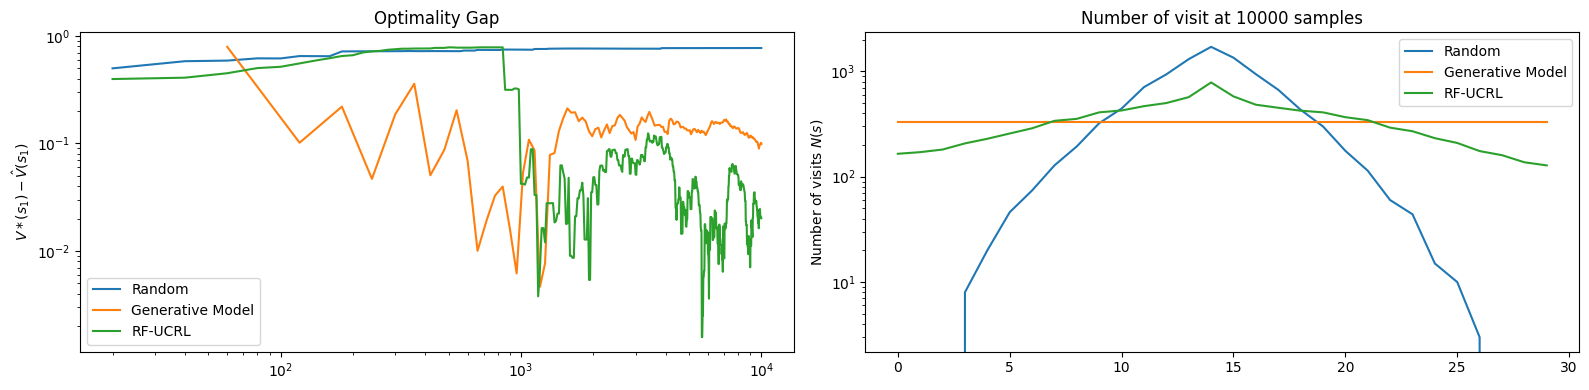

In [60]:
# plot results
samples_to_collect = 10000
algos = {
    "Random": random_explore, 
    "Generative Model": generative_model,
    "RF-UCRL": RF_UCRL,
}


plt.figure(figsize=(16, 4))
for name, algo in algos.items():
    num_samples, visit_SA, gaps = algo(double_chain, samples_to_collect)

    plt.subplot(1, 2, 1)
    plt.title("Optimality Gap")
    plt.plot(num_samples, gaps, label=name)
    plt.ylabel(r"$V*(s_1) - \hat{V}(s_1)$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"Number of visit at {samples_to_collect} samples")
    visit_S = visit_SA.sum(axis=1)
    plt.plot(visit_S, label=name)
    plt.ylabel(r"Number of visits $N(s)$")
    plt.yscale("log")
    plt.legend()

plt.tight_layout()

実は今回確認したRF-UCRLは、もともとはBest Policy Identification (BPI) のフレームワークで提案されたアルゴリズムです。
詳細は論文に任せますが、Reward Free RLでは十分なデータセットが集まったらアルゴリズムを終了＆データセットをReturnしていたのに対して、BPIでは方策の価値関数が十分収束したと判断した場合に, 一番良い方策をReturnします。